# Sun Access Example


## 0. Initialization

### 0.1. Importing libraries and setting global variables

In [1]:
import EN_17037_Recipes as enr 
import os
import trimesh as tm 
import pyvista as pv
import ladybug as lb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from honeybee_plus.radiance.recipe.solaraccess.gridbased import SolarAccessGridBased
from honeybee_plus.radiance.analysisgrid import AnalysisGrid

cwd = os.getcwd()
src = os.path.dirname(cwd)

Path to radiance is set to: /usr/local/radiance
Path to perl is set to: /usr/bin


### 0.2. Importing geometries and assigning materials

In [2]:
# create the material dictionary
material_dict = {
    "material_plastic": enr.material_plastic,
    "material_glass": enr.material_glass
}

# load the surface information table
surface_df = pd.read_csv("sa_file_table.csv")
surface_df

,surface_name,surface_type,file_path,material_name
0,wall,0,ref_room_walls.obj,material_plastic
1,window,5,ref_room_window.obj,material_glass


In [3]:
# loading all meshes and converting them into hb surfaces
hb_surfaces = []
for _, srf in surface_df.iterrows():
    filepath = os.path.join(src, "data", srf["file_path"])
    mesh = pv.read(filepath)
    hb_surf = enr.pv_mesh_to_hbsurface(mesh, srf["surface_type"], srf["surface_name"], material_dict[srf["material_name"]])
    hb_surfaces.extend(hb_surf)

### 0.3. Prepare Analysis Information

In [4]:
# generate grid of test points
grid_path = os.path.join(src, "data", "point_grid_sunacc.csv")
grid_array = np.genfromtxt(grid_path, delimiter=",")
pnts = [tuple(pnt) for pnt in grid_array] if len(grid_array.shape) == 2 else [tuple(grid_array)]
up_vecs = [(0, 0, 1)] * len(pnts)
analysis_grid = AnalysisGrid.from_points_and_vectors(pnts, up_vecs, 'test_grid')


# initiate sunpath
sp = lb.sunpath.Sunpath(longitude=4.3571, latitude=52.0116)

# define sun hours : A list of hours of the year for each sun vector
# there are 8760 hours in a year, so the following integers refer to specific hours throughout the year
hoys = []
sun_vectors = []
hoy_range = np.arange(0, 8760, 1.5)
for i in hoy_range:
    # compute the sun object
    sun = sp.calculate_sun_from_hoy(i)
    # extract the sun vector
    sun_vector = sun.sun_vector.to_array()
    # apparently, if the Z component of sun vector is positive, it is under the horizon 
    if sun_vector[2] < 0.0:
        hoys.append(i)
        sun_vectors.append(sun_vector)

## 1. Simulation

### 1.1. Create Recipe

In [5]:
# put the recipe together
rp = SolarAccessGridBased(sun_vectors, hoys, [analysis_grid], hb_objects=hb_surfaces)

Found 80 opaque surfaces.
Found 1 fenestration surfaces.
Found 0 window-groups.


### 1.2. Create Batch Files

In [6]:
# write simulation to folder
project_name = 'EN_17037_sun_access'
batch_file = rp.write(
    target_folder='.', project_name = project_name)

Writing recipe contents to: ./EN_17037_sun_access/solaraccess


### 1.3. Run the simulation

In [7]:
# run the simulation
rp.run(batch_file, debug=False)

True

## 2. Results

In [8]:
def parse_results(rp, aggregate=False):

    df = pd.read_csv(rp._result_files, skiprows=13, sep='\t', header=None)

    if not aggregate:
        return df
    else:
        return df.sum(axis=1) / df.shape[0]

In [9]:
result = parse_results(rp, aggregate=False)
print(result)

       0       1         2         3         4         5         6     \
0  0.001089  0.0026  0.003164  0.002686  0.001246  0.001096  0.002612   

       7         8         9     ...      2956      2957      2958      2959  \
0  0.003183  0.002709  0.001272  ...  0.002578  0.003129  0.002639  0.001191   

       2960      2961      2962      2963      2964  2965  
0  0.001083  0.002587  0.003144  0.002659  0.001215   NaN  

[1 rows x 2966 columns]


<AxesSubplot:>

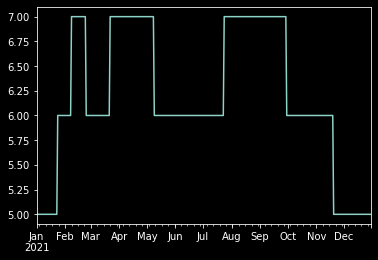

In [10]:
# reminder - the HOY indexes for the period 1st Feb and 21st March (included) are 258 and 774

point = 0

dates = pd.date_range(start='01-01-2021', end='31-12-2021 23:59:00', freq='90min')
result_timed = pd.DataFrame(index=hoy_range, columns=['date','res','bin'], dtype='object')
result_timed['date'] = list(dates)
result_timed.loc[hoys,'res'] = result.iloc[point,:-1].values
result_timed['bin'] = 1
result_timed.index = dates
result_timed.loc[:,'bin'] = result_timed.loc[:,'bin'].where(result_timed['res']>0,other=0)

# count of hours with sunlight access in a day (01/02 - 21/03)
result_day = result_timed['bin'].resample('D').sum()
result_day.plot()

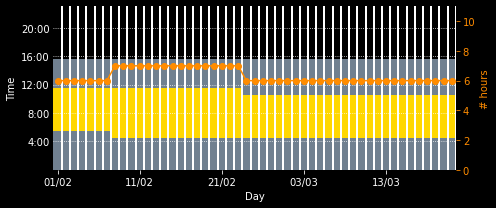

In [11]:
fig, ax1 = plt.subplots(figsize=(7,3))

cmap = colors.ListedColormap(['slategrey', 'gold'])
bounds=[0,.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
# ax.get_xaxis().set_ticks([])

ax1.imshow(result_timed['2021-02-01':'2021-03-21']['bin'].values.reshape(49,-1).T, 
           aspect='auto', origin='lower', cmap=cmap, norm=norm)
ax1.set_ylabel('Time')
ax1.set_xlabel('Day')
ax1.set_yticks(range(0,24,4))
ax1.set_yticklabels(['','4:00','8:00','12:00','16:00','20:00'])
ax1.tick_params(axis='y', length=0)
ax1.set_xticks(range(0,49,10))
ax1.set_xticklabels(['01/02','11/02','21/02','03/03','13/03'])
ax1.grid(axis='y', color='w', ls=':')
ax1.set_ylim(0,23)


ax2 = ax1.twinx()

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

for i in range(49):
    ax2.axvline(i+0.5, color='w', lw=2)
ax2.plot(result_day['2021-02-01':'2021-03-21'].values, marker='o', color='darkorange')
ax2.set_ylabel('# hours', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange', color='darkorange')
ax2.set_ylim(0,11)


fig.tight_layout()
plt.show()